## Part 1 : Data loading and preprocessing

In [188]:
import pandas as pd
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import iqr
import glob
import os

import warnings 
warnings.filterwarnings('ignore')

In [189]:
arts_pre  = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "dataset/Articles*.csv"))))
comms_pre = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "dataset/Comments*.csv"))))

#remove features that i don't need
comms_pre.drop(['printPage','parentUserDisplayName','picURL','recommendedFlag','userID',
            'permID','userTitle','userDisplayName','userURL','userLocation',
            'reportAbuseFlag', 'status','inReplyTo','commentSequence','commentTitle',
            'commentType', 'approveDate', 'createDate','updateDate','parentID'],
           axis=1,inplace=True)

arts_pre.drop(['abstract', 'documentType','multimedia', 'printPage',
           'pubDate','snippet','source','webURL'],
          axis=1,inplace=True)

In [190]:
print(comms_pre.shape) # ~2e6 comments with 34 features each
print(arts_pre.shape) #9300 comments with 15 features each

(2176364, 14)
(9335, 8)


#### Data preprocessing

In [191]:
#remove bad characters such as & and <br/>
def preprocess(commentBody):
    commentBody = commentBody.str.replace("(<br/>)", "")
    commentBody = commentBody.str.replace('(<a).*(>).*(</a>)', '')
    commentBody = commentBody.str.replace('(&amp)', '')
    commentBody = commentBody.str.replace('(&gt)', '')
    commentBody = commentBody.str.replace('(&lt)', '')
    commentBody = commentBody.str.replace('(\xa0)', ' ')  
    return commentBody

comms_pre.commentBody = preprocess(comms_pre.commentBody)

In [192]:
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

Stemmer = PorterStemmer()
stops = set(stopwords.words("english"))

In [193]:
def cleanList(myList):
    cleanedList = []
    for i,el in enumerate(myList):
        cleanedList.append(cleanText(el))
        print(str(i),end='\r')
    return cleanedList


def cleanText(rawText):

    nice_words   = [Stemmer.stem(word) for word in word_tokenize(rawText.lower()) if word.isalpha() and word not in stopwords.words("english")]
    joined_words = ( " ".join(nice_words))

    return joined_words

#### Don't run this cells: they are very slow. Instead load the already-cleaned csv files

In [194]:
#full_comms = list(comms_pre['commentBody'])

#clean_comm_bodies = cleanList(full_comms)

##Add cleaned data back into DataFrame
#comms_pre['commentBody'] = clean_comm_bodies
#comms_pre.to_csv("dataset/All_Comments_clean.csv",header=True)

In [195]:
arts_pre.to_csv("dataset/All_Articles_clean.csv",header=True)

In [196]:
arts = pd.read_csv("dataset/All_Articles_clean.csv")
comms = pd.read_csv("dataset/All_Comments_clean.csv")

In [197]:
comms = comms[comms.commentBody.notnull()]
comms.drop(['Unnamed: 0'], axis=1, inplace=True)
arts.drop(['Unnamed: 0'], axis=1, inplace=True)
arts.drop_duplicates(subset='articleID',keep='first')
comms = comms.drop_duplicates(subset='commentID',keep='first')

In [198]:
UnkHead = arts[ arts['headline'] == 'Unknown' ].index
arts.drop(UnkHead,inplace=True)

In [199]:
arts.headline.nunique()
# hints for hot topics
# beware! Different number of articles/comments
# keep track of this (maybe weigh on total number)
print(arts.shape)

(8603, 8)


## Part 2

### Assigning a score to each comment (AFINN-111 lexicon)

In [200]:
from afinn import Afinn
afinn = Afinn(language='en')

In [201]:
def comment_score (comment):
    commList = comment.split()
    tempScore = 0
    for word in commList:
        tempScore += afinn.score_with_wordlist(word)
    tempScore /= math.sqrt(len(commList)+1)
    return tempScore

In [202]:
#this takes some time (~1 min)
comms['commentScore'] = comms['commentBody'].apply(comment_score)

<AxesSubplot:>

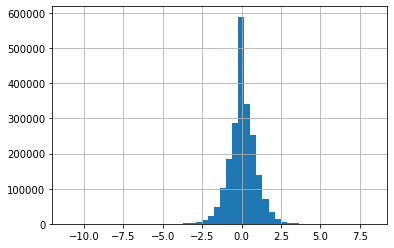

In [203]:
comms['commentScore'].hist(bins=50)

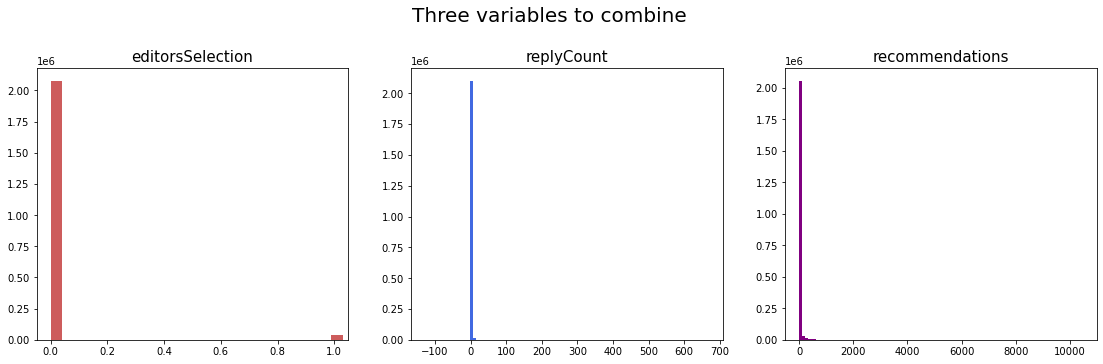

editorsSelection:  0  -  1
replyCount:  -128.0  -  668.0
recommendations:  0.0  -  10472.0


In [204]:
fig, axs = plt.subplots(1, 3, figsize=(19, 5))
fig.suptitle('Three variables to combine', fontsize=20, y=1.05)

axs[0].hist(comms['editorsSelection'],bins=100, color='indianred', width=0.04)
axs[0].set_title('editorsSelection', fontsize=15)
axs[1].hist(comms['replyCount'],bins=100, color='royalblue')
axs[1].set_title('replyCount', fontsize=15)
#axs[1].set_xlim(0,670)
axs[2].hist(comms['recommendations'],bins=100, color='purple')
axs[2].set_title('recommendations', fontsize=15)
#axs[2].set_xlim(0,10000)

plt.show()


print("editorsSelection: ", comms['editorsSelection'].min(), " - ", comms['editorsSelection'].max())
print("replyCount: ", comms['replyCount'].min(),  " - ", comms['replyCount'].max())
print("recommendations: ", comms['recommendations'].min(), " - ", comms['recommendations'].max())

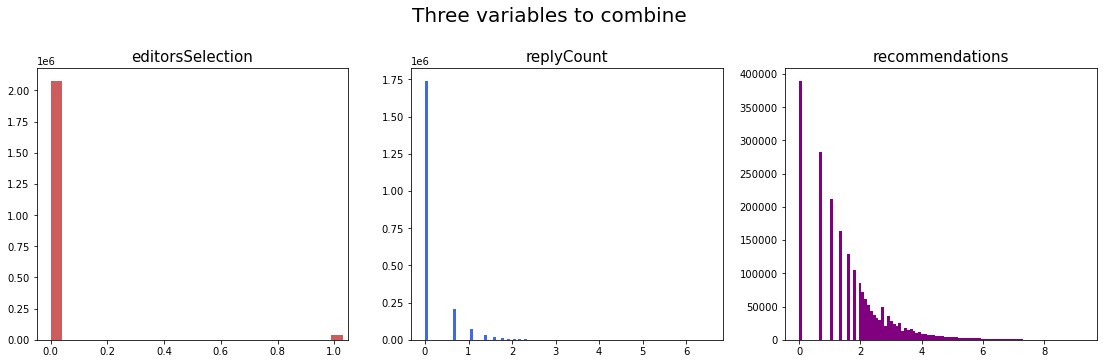

editorsSelection:  0  -  1
replyCount:  -128.0  -  668.0
recommendations:  0.0  -  10472.0


In [205]:
fig, axs = plt.subplots(1, 3, figsize=(19, 5))
fig.suptitle('Three variables to combine', fontsize=20, y=1.05)

axs[0].hist(comms['editorsSelection'],bins=100, color='indianred', width=0.04)
axs[0].set_title('editorsSelection', fontsize=15)
axs[1].hist(np.log(1 +comms['replyCount']),bins=100, color='royalblue')
axs[1].set_title('replyCount', fontsize=15)
#axs[1].set_xlim(0,670)
axs[2].hist(np.log(1 +comms['recommendations']),bins=100, color='purple')
axs[2].set_title('recommendations', fontsize=15)
#axs[2].set_xlim(0,10000)

plt.show()


print("editorsSelection: ", comms['editorsSelection'].min(), " - ", comms['editorsSelection'].max())
print("replyCount: ", comms['replyCount'].min(),  " - ", comms['replyCount'].max())
print("recommendations: ", comms['recommendations'].min(), " - ", comms['recommendations'].max())

In [206]:
#comms['success'] =(1 + comms['editorsSelection']) * np.log(1.05 + comms['replyCount']) * np.log(1.05 + comms['recommendations'])
#comms['success'] = (1 + comms['editorsSelection']) * (1 +comms['replyCount']) * (1 + comms['recommendations'])
#comms['success'] = (1 + comms['editorsSelection']) * ( comms['replyCount'] + comms['recommendations'])
#comms['success'] = (comms['success'] - comms['success'].mean()) / comms['success'].std()
#plt.hist((comms['success']), bins=250, color='orange')
#plt.grid(alpha=0.4)
#plt.xlim(-5,5)
#plt.show()
#comms['success'].describe()

#talk about many trials i did here

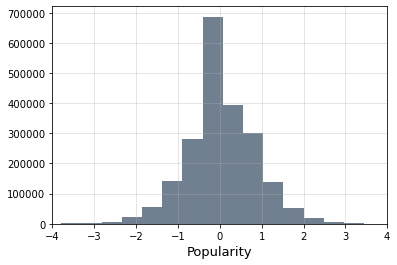

count    2.116353e+06
mean     6.547889e-02
std      8.224657e-01
min     -1.102646e+01
25%     -3.922323e-01
50%      0.000000e+00
75%      5.393599e-01
max      8.273292e+00
Name: popularity, dtype: float64

In [207]:
comms['popularity'] = comms['commentScore']
#comms['popularity'] = (1 + comms['editorsSelection']) * comms['commentScore']
plt.hist(comms['popularity'],bins=40, color='slategray')
plt.grid(alpha=0.4)
plt.xlim(-4,4)
plt.xlabel("Popularity",fontsize=13)
plt.show()
comms['popularity'].describe()

<AxesSubplot:>

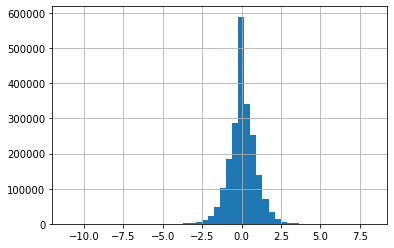

In [208]:
comms['commentScore'].hist(bins=50)

### Assign a score to each article

In [209]:
grouper = comms.groupby('articleID')
to_merge = grouper.sum().divide(np.sqrt(grouper.count()+1)).reset_index().rename(columns={'popularity': 'articleScore'})[['articleID', 'articleScore']]
arts = arts.merge(to_merge, on='articleID')

In [210]:
arts['articleScore'].describe()

count    8435.000000
mean        1.427923
std         3.675228
min       -23.884459
25%        -0.054026
50%         1.323850
75%         3.176885
max        52.087079
Name: articleScore, dtype: float64

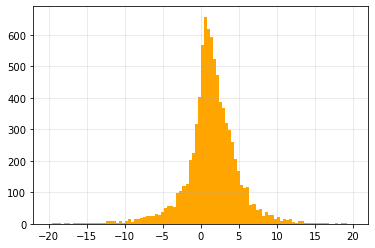

In [211]:
plt.hist(arts['articleScore'], bins=100, range=(-20,20), color='orange')
plt.grid(alpha=0.3)
plt.show()
# polarity distribution of the articles

### TF-IDF to create feature vector (skip for now)

In [298]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
vect = TfidfVectorizer()

In [299]:
corpus2 = [w for w in comms['commentBody']]

In [300]:
X = vect.fit_transform(corpus2)
X.shape

(2116353, 276388)

In [301]:
ch2 = SelectKBest(chi2,k=40)
X_new = ch2.fit_transform(X, comms['label'])

KeyError: 'label'

In [ ]:
feature_names = [vect.get_feature_names()[i] for i
                         in ch2.get_support(indices=True)]

In [ ]:
print(feature_names, sep=' ')

In [ ]:
#comms.sort_values(by='success',ascending=False,inplace=True)

## Part 3 : Defining controversy (popularity + debate)

In [215]:
arts_old = arts.copy(deep=False)

#### Strategy 1 : Popularity x debate

##### Popularity = Total number of comments under each article (normalized to be 0-100)

In [216]:
arts['commentNumber'] = arts['articleID'].map(comms['articleID'].value_counts())
arts['commentNumber'] = 100 * arts['commentNumber'] / arts['commentNumber'].max()

In [217]:
arts.sort_values(by='commentNumber',ascending=False, inplace=True)

##### Debate: interquartile range of the comment scores in an article (normalized to 0-1)

In [218]:
arts['debate'] = arts['articleID'].map(comms.groupby('articleID')['commentScore'].agg(iqr))
arts['debate'] = arts['debate'] / arts['debate'].max()

In [219]:
# Now finally controversiality

In [220]:
arts['controv'] =  arts['commentNumber'] * (0.001 + arts['debate'])
arts.sort_values(by='controv',ascending=False,inplace=True)
# Remember all trials!! (Without normalization, without epsilon, ...)

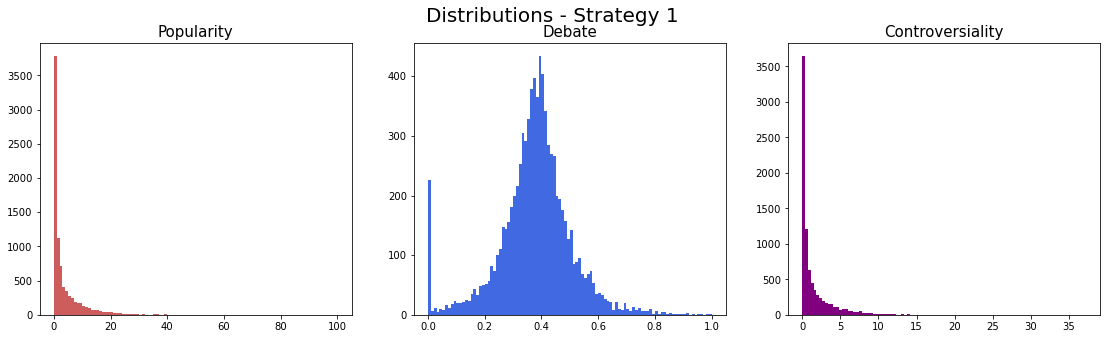

In [221]:
fig, axs = plt.subplots(1, 3, figsize=(19, 5))
fig.suptitle('Distributions - Strategy 1', fontsize=20)

axs[0].hist(arts['commentNumber'],bins=100, color='indianred')
axs[0].set_title('Popularity', fontsize=15)
axs[1].hist(arts['debate'],bins=100, color='royalblue')
axs[1].set_title('Debate', fontsize=15)
axs[2].hist(arts['controv'],bins=100, color='purple')
axs[2].set_title('Controversiality', fontsize=15)

plt.show()

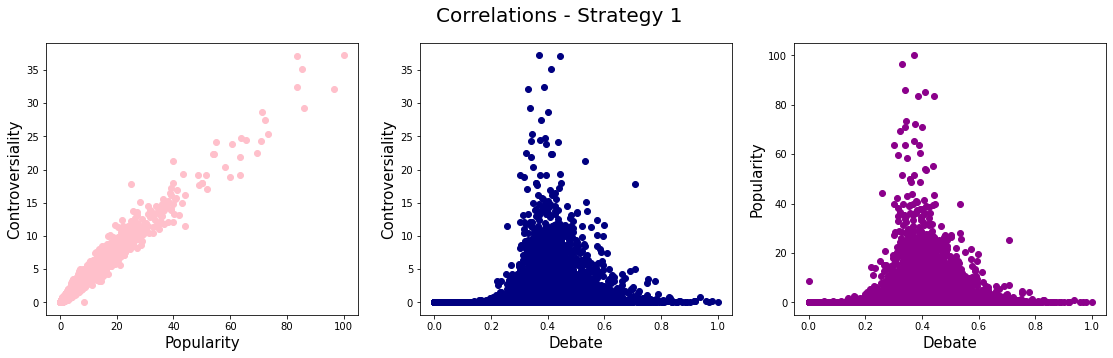

In [222]:
fig, axs = plt.subplots(1, 3, figsize=(19, 5))
fig.suptitle("Correlations - Strategy 1",fontsize=20)
axs[0].scatter(arts['commentNumber'],arts['controv'], color='pink')
axs[0].set_xlabel('Popularity', fontsize=15)
axs[0].set_ylabel('Controversiality', fontsize=15)
axs[1].scatter(arts['debate'], arts['controv'],color='navy')
axs[1].set_xlabel('Debate', fontsize=15)
axs[1].set_ylabel('Controversiality', fontsize=15)
axs[2].scatter( arts['debate'],arts['commentNumber'],color='darkmagenta')
axs[2].set_ylabel('Popularity', fontsize=15)
axs[2].set_xlabel('Debate', fontsize=15)

fig.show()

#### Strategy 2: log(Popularity) * Debate

In [225]:
arts2 = arts_old.copy(deep=False)

In [226]:
arts2['commentNumber'] = arts['articleID'].map(comms['articleID'].value_counts())
arts2['debate'] = arts['articleID'].map(comms.groupby('articleID')['commentScore'].agg(iqr))
arts2['logCommentNumber'] = 1 + np.log10(arts2['commentNumber'])
arts2['controv'] = arts2['logCommentNumber'] * (0.01 + arts2['debate'])

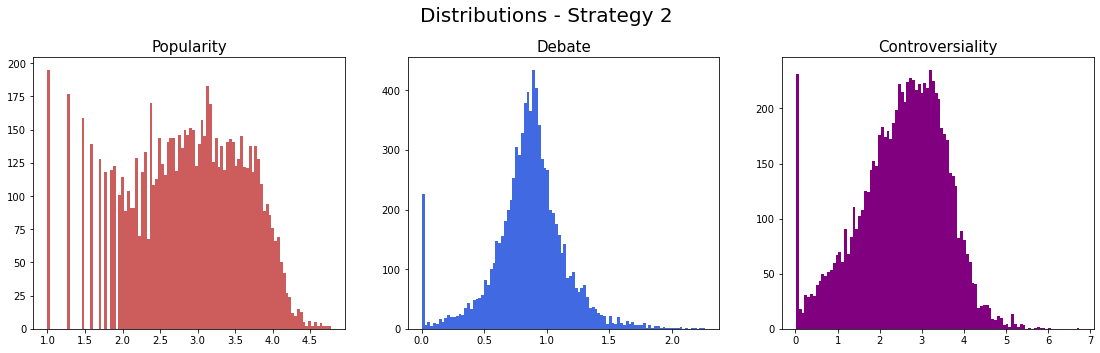

In [227]:
fig, axs = plt.subplots(1, 3, figsize=(19, 5))
fig.suptitle('Distributions - Strategy 2', fontsize=20, y=1.02)

axs[0].hist(arts2['logCommentNumber'],bins=100, color='indianred')
axs[0].set_title('Popularity', fontsize=15)
axs[1].hist(arts2['debate'],bins=100, color='royalblue')
axs[1].set_title('Debate', fontsize=15)
axs[2].hist(arts2['controv'],bins=100, color='purple')
axs[2].set_title('Controversiality', fontsize=15)

plt.show()

In [228]:
arts2.sort_values(by='controv',ascending=False,inplace=True)

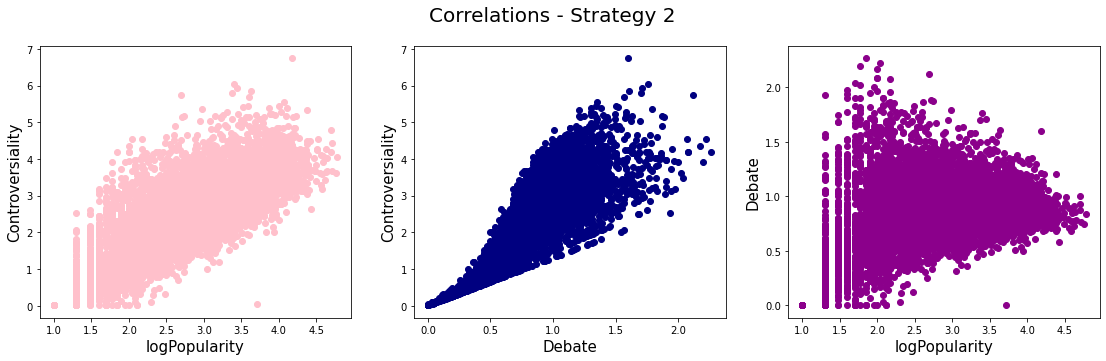

In [229]:
fig, axs = plt.subplots(1, 3, figsize=(19, 5))
fig.suptitle('Correlations - Strategy 2', fontsize=20, y=0.99)

axs[0].scatter(arts2['logCommentNumber'],arts2['controv'],color='pink')
axs[0].set_xlabel('logPopularity', fontsize=15)
axs[0].set_ylabel('Controversiality', fontsize=15)
axs[1].scatter(arts2['debate'], arts2['controv'], color='navy')
axs[1].set_xlabel('Debate', fontsize=15)
axs[1].set_ylabel('Controversiality', fontsize=15)
axs[2].scatter(arts2['logCommentNumber'], arts2['debate'], color='darkmagenta')
axs[2].set_xlabel('logPopularity', fontsize=15)
axs[2].set_ylabel('Debate', fontsize=15)

fig.show()

In [230]:
#arts2.head(10)

In [231]:
#arts2.tail(10)

## Part 4: Grouping by category

### Section name - Strategy 1

In [232]:
dftot = pd.DataFrame()
dftot['sectionName'] = arts['sectionName'].unique()
dftot.sort_values(by='sectionName',inplace=True)
grouper = arts.groupby('sectionName').mean()['controv']
grouper2 = arts.groupby('sectionName').mean()['commentNumber']
dftot['SecControv'] = dftot['sectionName'].map(grouper)
dftot['Popularity']= dftot['sectionName'].map(grouper2)
dftot['Popularity'] = dftot['Popularity'] * dftot['SecControv'].max() / dftot['Popularity'].max()
dftot.sort_values(by='SecControv',ascending=False,inplace=True)

In [233]:
dftot.sort_values(by='SecControv',ascending=False,inplace=True)

In [234]:
#fig, ax = plt.subplots(figsize=(5,25))
#ind = np.arange(len(dftot))
#wi = 0.4
#ax.barh(ind, dftot.SecControv, wi, color='green', label='Controverse')#
#ax.barh(ind + wi, dftot.Popularity, wi, color='red', label='Popular')

#ax.set(yticks=ind + wi, yticklabels=dftot.sectionName, ylim=[2*wi - 1, len(dftot)])
#ax.legend()
#plt.show()

#ax.barh(ind, df.n, width, color='red', label='N')
#ax.barh(ind + width, df.m, width, color='green', label='M')

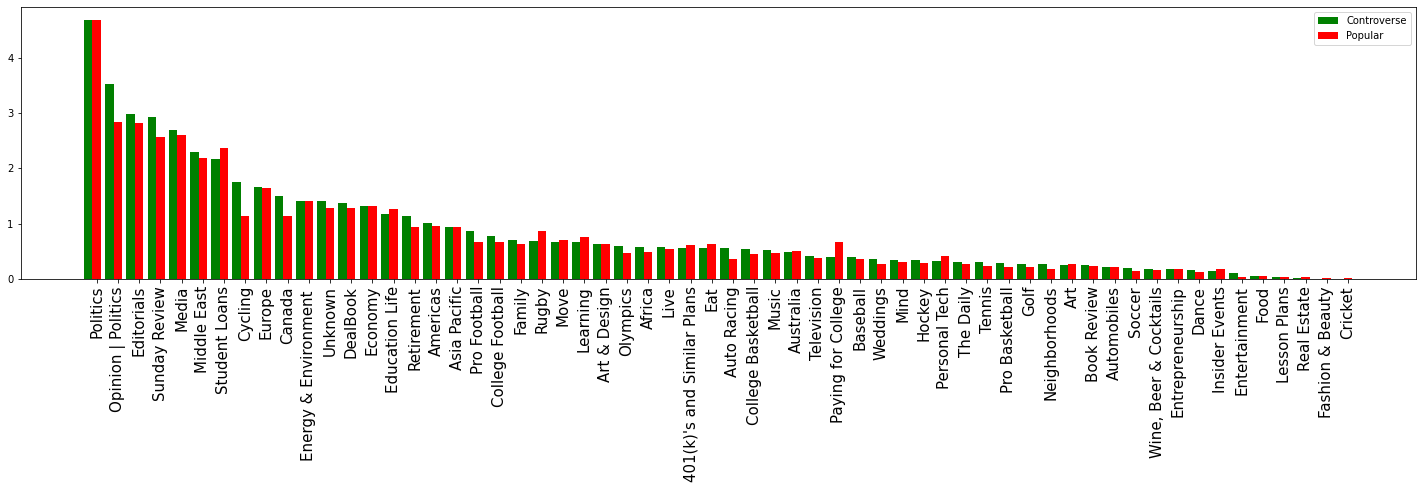

In [235]:
fig, ax = plt.subplots(figsize=(25,5))
ind = np.arange(len(dftot))
wi = 0.4
ax.bar(ind, dftot.SecControv, wi, color='green', label='Controverse')
ax.bar(ind + wi, dftot.Popularity, wi, color='red', label='Popular')

ax.set(xticks=ind + wi, xticklabels=dftot.sectionName)
plt.xticks(fontsize=15, rotation=90)
ax.legend()
plt.show()

### Section Name - Strategy 2

In [236]:
dftot = pd.DataFrame()
dftot['sectionName'] = arts['sectionName'].unique()
dftot.sort_values(by='sectionName',inplace=True)
grouper = arts2.groupby('sectionName').mean()['controv']
grouper2 = arts2.groupby('sectionName').mean()['commentNumber']
dftot['SecControv'] = dftot['sectionName'].map(grouper)
dftot['Popularity']= dftot['sectionName'].map(grouper2)
dftot['Popularity'] = dftot['Popularity'] * dftot['SecControv'].max() / dftot['Popularity'].max()
dftot.sort_values(by='SecControv',ascending=False,inplace=True)

In [237]:
#fig, ax = plt.subplots(figsize=(5,25))
#ind = np.arange(len(dftot))
#wi = 0.4
#ax.barh(ind, dftot.SecControv, wi, color='green', label='Controverse')
#ax.barh(ind + wi, dftot.Popularity, wi, color='red', label='Popular')

#ax.set(yticks=ind + wi, yticklabels=dftot.sectionName, ylim=[2*wi - 1, len(dftot)])
#ax.legend()
#plt.show()

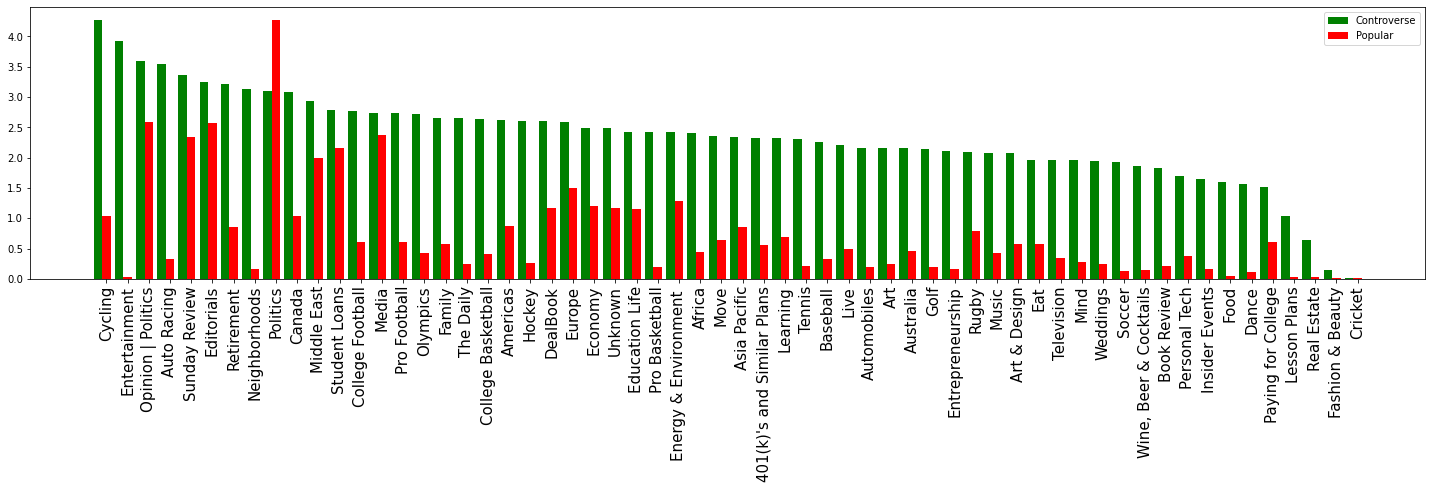

In [238]:
fig, ax = plt.subplots(figsize=(25,5))
ind = np.arange(len(dftot))
wi = 0.4
ax.bar(ind, dftot.SecControv, wi, color='green', label='Controverse')
ax.bar(ind + wi, dftot.Popularity, wi, color='red', label='Popular')

ax.set(xticks=ind + wi, xticklabels=dftot.sectionName)
plt.xticks(fontsize=15, rotation=90)
ax.legend()
plt.show()

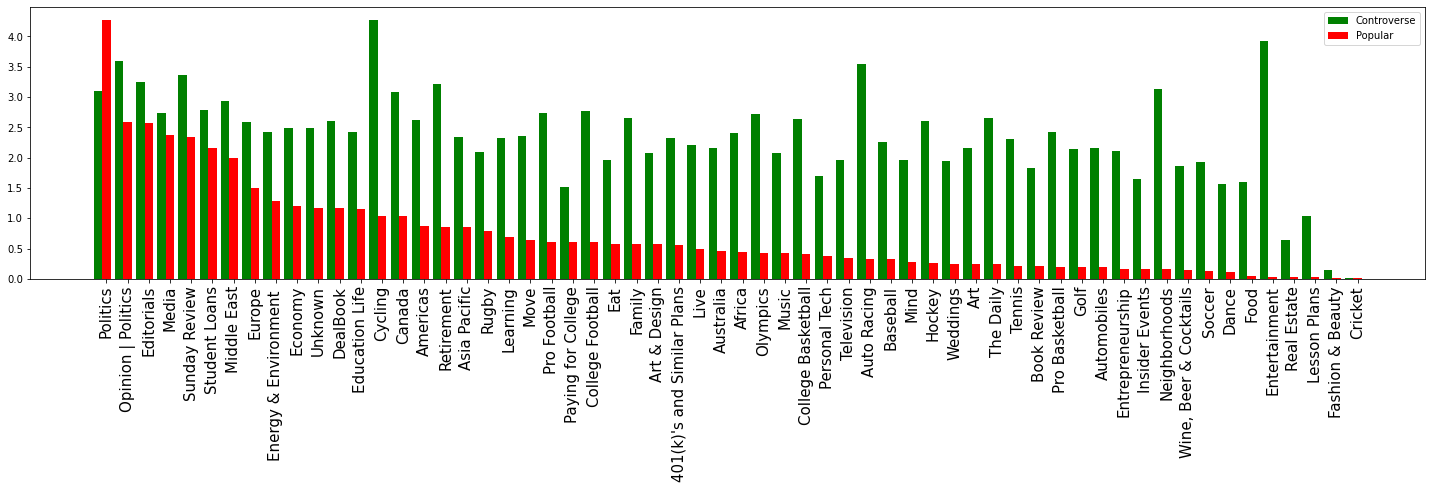

In [239]:
dftot.sort_values(by='Popularity',ascending=False,inplace=True)
fig, ax = plt.subplots(figsize=(25,5))
ind = np.arange(len(dftot))
wi = 0.4
ax.bar(ind, dftot.SecControv, wi, color='green', label='Controverse')
ax.bar(ind + wi, dftot.Popularity, wi, color='red', label='Popular')

ax.set(xticks=ind + wi, xticklabels=dftot.sectionName)
plt.xticks(fontsize=15, rotation=90)
ax.legend()
plt.show()

### Grouping by NewDesk - Strategy 1

In [242]:
dftot = pd.DataFrame()
dftot['newDesk'] = arts['newDesk'].unique()
dftot.sort_values(by='newDesk',inplace=True)
grouper = arts.groupby('newDesk').mean()['controv']
grouper2 = arts.groupby('newDesk').mean()['commentNumber']
dftot['SecControv'] = dftot['newDesk'].map(grouper)
dftot['Popularity']= dftot['newDesk'].map(grouper2)
dftot['Popularity'] = dftot['Popularity'] * dftot['SecControv'].max() / dftot['Popularity'].max()
dftot.sort_values(by='SecControv',ascending=False,inplace=True)

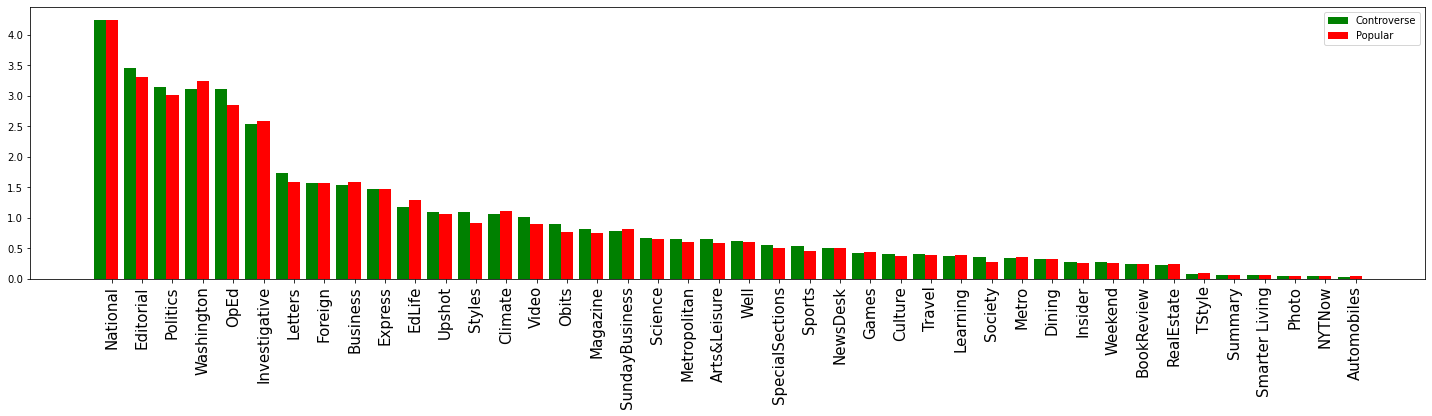

In [243]:
fig, ax = plt.subplots(figsize=(25,5))
ind = np.arange(len(dftot))
wi = 0.4
ax.bar(ind, dftot.SecControv, wi, color='green', label='Controverse')
ax.bar(ind + wi, dftot.Popularity, wi, color='red', label='Popular')

ax.set(xticks=ind + wi, xticklabels=dftot.newDesk)
plt.xticks(fontsize=15, rotation=90)
ax.legend()
plt.show()

### Strategy 2

In [245]:
dftot = pd.DataFrame()
dftot['newDesk'] = arts2['newDesk'].unique()
dftot.sort_values(by='newDesk',inplace=True)
grouper = arts2.groupby('newDesk').mean()['controv']
grouper2 = arts2.groupby('newDesk').mean()['commentNumber']
dftot['SecControv'] = dftot['newDesk'].map(grouper)
dftot['Popularity']= dftot['newDesk'].map(grouper2)
dftot['Popularity'] = dftot['Popularity'] * dftot['SecControv'].max() / dftot['Popularity'].max()
dftot.sort_values(by='SecControv',ascending=False,inplace=True)

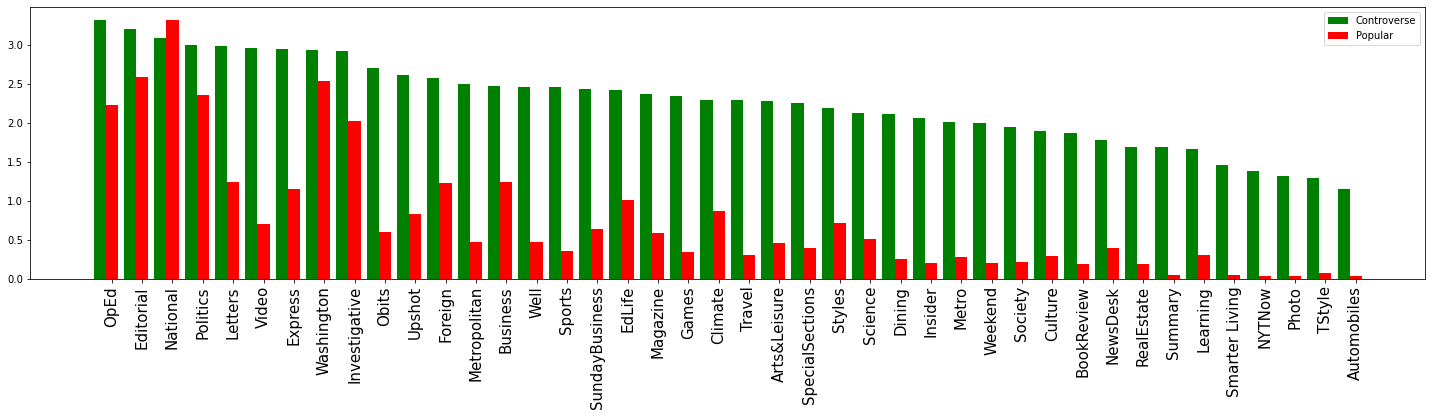

In [246]:
fig, ax = plt.subplots(figsize=(25,5))
ind = np.arange(len(dftot))
wi = 0.4
ax.bar(ind, dftot.SecControv, wi, color='green', label='Controverse')
ax.bar(ind + wi, dftot.Popularity, wi, color='red', label='Popular')

ax.set(xticks=ind + wi, xticklabels=dftot.newDesk)
plt.xticks(fontsize=15, rotation=90)
ax.legend()
plt.show()

#### Grouping by AUTHOR - Strategy 2

In [247]:
# I have to select only authors with 20+ articles

In [251]:
dftot = pd.DataFrame()
dftot['byline'] = arts2['byline'].unique()
grp = arts2.groupby('byline')['newDesk'].count()
dftot['artNum'] = dftot['byline'].map(grp)
#grouper = arts2.groupby('byline').count()
#grouper
dftot.sort_values(by='artNum',ascending=False, inplace=True)
dftot = dftot[ dftot['artNum']> 30 ]

In [252]:
dftot.sort_values(by='byline',inplace=True)
grouper = arts2.groupby('byline').mean()['controv']
grouper2 = arts2.groupby('byline').mean()['commentNumber']
dftot['SecControv'] = dftot['byline'].map(grouper)
dftot['Popularity']= dftot['byline'].map(grouper2)
dftot['Popularity'] = dftot['Popularity'] * dftot['SecControv'].max() / dftot['Popularity'].max()
dftot.sort_values(by='SecControv',ascending=False,inplace=True)

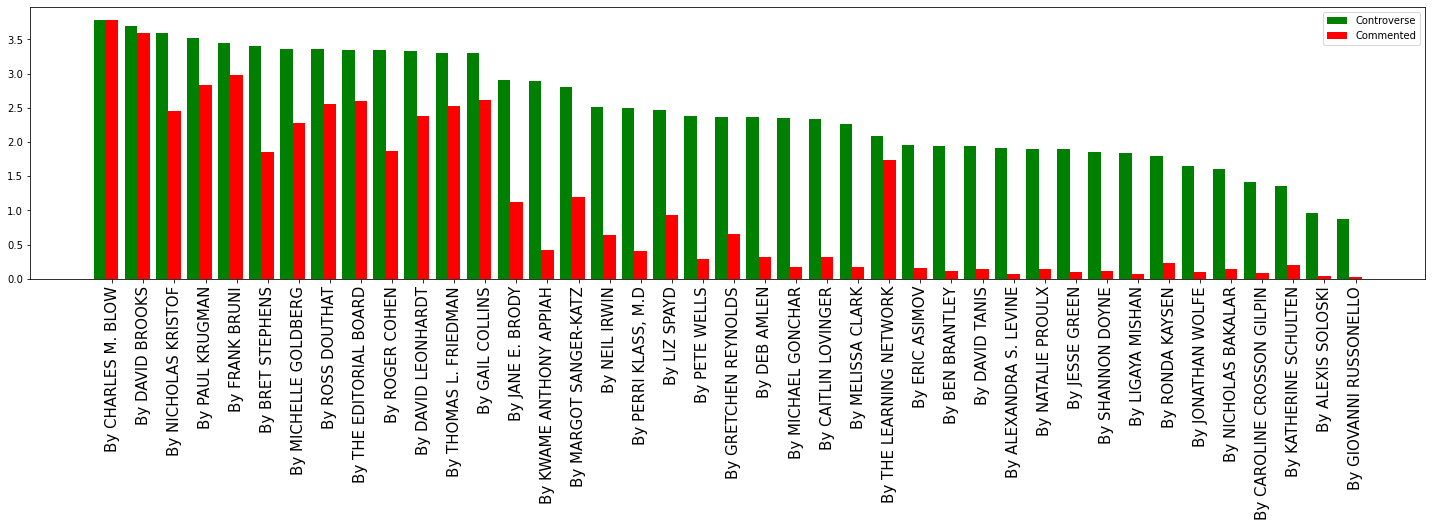

In [253]:
fig, ax = plt.subplots(figsize=(25,5))
ind = np.arange(len(dftot))
wi = 0.4
ax.bar(ind, dftot.SecControv, wi, color='green', label='Controverse')
ax.bar(ind + wi, dftot.Popularity, wi, color='red', label='Commented')

ax.set(xticks=ind + wi, xticklabels=dftot.byline)
plt.xticks(fontsize=15, rotation=90)
ax.legend()
plt.show()

### TF-IDF to extract 'controversial words'

In [284]:
def Discretize(x):
    if x>1:
        return 2
    elif 0<x<1:
        return 1
    elif -1<x<0:
        return -1
    else:
        return-1

In [265]:
# I need to keep only most controversial comments
# that is, all comments related to most controversial articles
# (reverse groupby)

In [268]:
dfcon = pd.DataFrame()
arts2.sort_values(by='controv',ascending=False)
first10percent = int(len(arts2)/10)
dfcon = arts2.head(first10percent)

In [290]:
topIDs = list (dfcon['articleID'])
comms_elite = comms [ comms['articleID'].isin (topIDs) ]
#comms_elite['commentScore'].hist(bins=100)
comms_elite['label'] = round(comms['commentScore'])
comms_elite

,articleID,articleWordCount,commentBody,commentID,depth,editorsSelection,newDesk,recommendations,replyCount,sectionName,sharing,timespeople,trusted,typeOfMaterial,commentScore,popularity,label
5212,5a7309a610f40f00018bef1b,1113.0,leav leav alon,26767918.0,1.0,0,Well,0.0,0.0,Mind,1,1.0,0.0,News,0.000000,0.000000,0.0
5213,5a7309a610f40f00018bef1b,1113.0,last juli beauti sunni day south sweet funni b...,26756072.0,1.0,0,Well,1.0,0.0,Mind,0,1.0,0.0,News,-0.179605,-0.179605,-0.0
5214,5a7309a610f40f00018bef1b,1113.0,depress albatross even person admit depress ch...,26595362.0,1.0,0,Well,2.0,0.0,Mind,0,1.0,0.0,News,-0.102598,-0.102598,-0.0
5215,5a7309a610f40f00018bef1b,1113.0,plea googl articl stat news novemb stat news t...,26606427.0,1.0,0,Well,2.0,0.0,Mind,0,1.0,0.0,News,0.359211,0.359211,0.0
5216,5a7309a610f40f00018bef1b,1113.0,may share recommend tri cope tini tool toolbox...,26350387.0,1.0,0,Well,2.0,0.0,Mind,1,1.0,0.0,News,1.740777,1.740777,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2169420,58b5fc0295d0e024902fcbe1,1511.0,make even disgust ignor two person galleri ang...,21651815.0,2.0,0,National,0.0,0.0,Politics,1,1.0,0.0,News,-1.566699,-1.566699,-2.0
2169421,58b5fc0295d0e024902fcbe1,1511.0,would think lie bad judgement also involv fake...,21652218.0,2.0,0,National,0.0,0.0,Politics,0,1.0,0.0,News,-1.664101,-1.664101,-2.0
2169422,58b5fc0295d0e024902fcbe1,1511.0,time give thing go beyond constitut give us ba...,21650437.0,2.0,0,National,6.0,0.0,Politics,0,1.0,0.0,News,0.000000,0.000000,0.0
2169423,58b5fc0295d0e024902fcbe1,1511.0,agr healthcar ever afford anyon know problem l...,21650776.0,2.0,0,National,4.0,0.0,Politics,0,1.0,0.0,News,0.437595,0.437595,0.0


In [296]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
vect = TfidfVectorizer()

corpus2 = [w for w in comms_elite['commentBody']]

X = vect.fit_transform(corpus2)
X.shape

ch2 = SelectKBest(chi2,k=150)
X_new = ch2.fit_transform(X, y=comms_elite['label'])

feature_names = [vect.get_feature_names()[i] for i in ch2.get_support(indices=True)]

print(feature_names, sep=' ')

#comms.sort_values(by='success',ascending=False,inplace=True)

['againoh', 'againthank', 'againto', 'ahia', 'allamerica', 'ami', 'anger', 'assault', 'attack', 'autoworkerson', 'award', 'awayat', 'bad', 'ban', 'bednarik', 'best', 'bestpart', 'better', 'blame', 'bless', 'borderunmatch', 'brilliant', 'care', 'champagneth', 'childreni', 'choicethat', 'chuch', 'condem', 'corrupt', 'crime', 'culumn', 'danger', 'dangermi', 'dayno', 'dead', 'death', 'destroy', 'die', 'disgust', 'drugsw', 'einstien', 'enjoy', 'evil', 'fake', 'fan', 'fear', 'fire', 'flaga', 'fraud', 'fun', 'furthburn', 'futurea', 'gift', 'glad', 'good', 'great', 'gun', 'ha', 'hanh', 'harass', 'hate', 'health', 'hee', 'help', 'heritagelet', 'heroesgreat', 'ho', 'holdback', 'hope', 'ihat', 'ispeopl', 'joband', 'jobth', 'journeyi', 'joy', 'justicethi', 'kill', 'liar', 'lightjobless', 'like', 'lost', 'love', 'luck', 'lutey', 'midig', 'militarywho', 'murder', 'mv', 'nice', 'okayso', 'oldtim', 'omertà', 'payunsightli', 'pei', 'peopleth', 'perfect', 'pima', 'playal', 'poorkil', 'prison', 'problem'

In [307]:
featurestring = ' '.join(word for word in feature_names)

In [308]:
real_features = afinn.find_all(featurestring)

In [310]:
print(real_features, sep=' ')

['anger', 'assault', 'attack', 'award', 'bad', 'ban', 'best', 'better', 'blame', 'bless', 'brilliant', 'care', 'corrupt', 'crime', 'danger', 'dead', 'death', 'destroy', 'die', 'disgust', 'enjoy', 'evil', 'fake', 'fan', 'fear', 'fire', 'fraud', 'fun', 'gift', 'glad', 'good', 'great', 'gun', 'ha', 'harass', 'hate', 'help', 'hope', 'joy', 'kill', 'liar', 'like', 'lost', 'love', 'luck', 'murder', 'nice', 'perfect', 'prison', 'problem', 'punish', 'racism', 'racist', 'rape', 'rapist', 'shame', 'share', 'shoot', 'stupid', 'super', 'superb', 'support', 'terror', 'terrorist', 'thank', 'treason', 'true', 'victim', 'violent', 'war', 'warn', 'wealth', 'win', 'winner', 'worst', 'wow', 'wrong', 'xoxoxo']
